[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)

# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things: 

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!
 
In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GOOGLE_API_KEY")

We'll use [LangSmith](https://docs.langchain.com/langsmith/home) for [tracing](https://docs.langchain.com/langsmith/observability-concepts).

We'll log to a project, `langchain-academy`. 

In [2]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Messages as state

First, let's define some messages.

In [3]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage


messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


Recall we can pass them to a chat model.

In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)
llm.invoke(messages)

AIMessage(content='That\'s a great question! While whales (cetaceans) are certainly iconic, the ocean is home to a diverse array of other fascinating mammals. Here are some major groups and specific examples you should definitely learn about:\n\n1.  **Pinnipeds (Seals, Sea Lions, and Walruses)**\n    These are semi-aquatic marine mammals, meaning they spend time both in the water and on land (or ice). They\'re characterized by their flippers.\n\n    *   **Seals (True Seals / Phocids):**\n        *   **Characteristics:** No external ear flaps, short front flippers, move on land by "wiggling" their bodies. They are generally more streamlined for water.\n        *   **Examples:**\n            *   **Harbor Seal:** Common along temperate coastlines.\n            *   **Harp Seal:** Known for their striking white pups.\n            *   **Elephant Seal:** The largest seals, famous for the male\'s proboscis (trunk-like nose) and deep-diving abilities.\n            *   **Leopard Seal:** Apex pre

We can run our chat model in a simple graph with `MessagesState`.

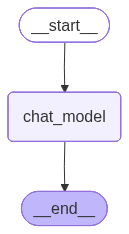

In [5]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's a great area to research! While whales (cetaceans) are fascinating, there's a whole world of other incredible ocean mammals. Here are some major groups and specific examples you should definitely learn about:

1.  **Pinnipeds (Seals, Sea Lions, and Walruses)**
    These are semi-aquatic marine mammals, meaning they spend time both in the water and on land (or ice).

    *   **True Seals (Phocidae):**
        *   **Characteristics:** No external ear flaps, move on land by wriggling their bodies (like a caterpillar), use their hind flippers for propulsion in water.
        *   **Examples:**
            *   *

## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

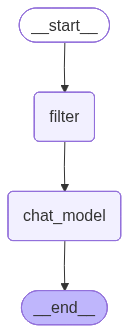

In [7]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)

builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's a great area to research! While whales (cetaceans) are fascinating, there's a whole world of other incredible ocean mammals. Here are some major groups and specific examples you should definitely learn about:

1.  **Pinnipeds (Seals, Sea Lions, and Walruses)**
    These are semi-aquatic marine mammals, meaning they spend time both in the water and on land (or ice).

    *   **True Seals (Phocidae):**
        *   **Characteristics:** No external ear flaps, move on land by wriggling their bodies (like a caterpillar), use their hind flippers for propulsion in water.
        *   **Examples:**
            *   *

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

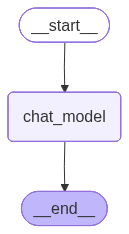

In [13]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [19]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [20]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's a great area to research! While whales (cetaceans) are fascinating, there's a whole world of other incredible ocean mammals. Here are some major groups and specific examples you should definitely learn about:

1.  **Pinnipeds (Seals, Sea Lions, and Walruses)**
    These are semi-aquatic marine mammals, meaning they spend time both in the water and on land (or ice).

    *   **True Seals (Phocidae):**
        *   **C

In [23]:
messages[-1:]

[HumanMessage(content='Tell me more about Narwhals!', additional_kwargs={}, response_metadata={}, name='Lance', id='75bb1da6-af79-446b-a202-8aef00ea6f07')]

In [21]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's a great area to research! While whales (cetaceans) are fascinating, there's a whole world of other incredible ocean mammals. Here are some major groups and specific examples you should definitely learn about:

1.  **Pinnipeds (Seals, Sea Lions, and Walruses)**
    These are semi-aquatic marine mammals, meaning they spend time both in the water and on land (or ice).

    *   **True Seals (Phocidae):**
        *   **C

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## Trim messages

Another approach is to [trim messages](https://docs.langchain.com/oss/python/langgraph/add-memory#trim-messages), based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

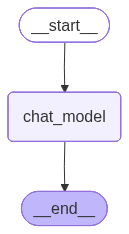

In [30]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=llm,
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
output['messages'][-1]

AIMessage(content='Narwhals are truly one of the most fascinating and enigmatic creatures of the Arctic! Often called the "unicorns of the sea" due to their distinctive tusk, they are a type of toothed whale (odontocete) closely related to beluga whales.\n\nHere\'s a deeper dive into what makes narwhals so unique:\n\n1.  **The Tusk: A Sensory Organ, Not a Weapon**\n    *   **What it is:** The narwhal\'s famous "horn" is actually an elongated canine tooth that can grow up to 10 feet (3 meters) long in males, spiraling counter-clockwise. A small percentage of females also grow a tusk, and very rarely, a narwhal might have two tusks.\n    *   **Purpose:** For a long time, its function was a mystery. Scientists now believe it\'s primarily a highly sensitive **sensory organ**. It\'s covered in millions of nerve endings that can detect changes in water temperature, pressure, salinity, and even the presence of prey. It\'s like an underwater antenna!\n    *   **Other uses:** While not its prim

In [32]:
messages

[AIMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Bot', id='1'),
 HumanMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Lance', id='2'),
 AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
 HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='4'),
 AIMessage(content='That\'s a great area to research! While whales (cetaceans) are fascinating, there\'s a whole world of other incredible ocean mammals. Here are some major groups and specific examples you should definitely learn about:\n\n1.  **Pinnipeds (Seals, Sea Lions, and Walruses)**\n    These are semi-aquatic marine mammals, meaning they spend time both in the water and on land (or ice).\n\n    *   **True Seals (Phocidae):**\n        *   **Characteristics:** No external ear flaps, move on land by wriggling t

In [33]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [34]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=llm,
            allow_partial=False
        )

[HumanMessage(content='Tell me where Orcas live!', additional_kwargs={}, response_metadata={}, name='Lance')]

In [35]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages})

In [36]:
messages_out_trim

{'messages': [AIMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Bot', id='1'),
  HumanMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Lance', id='2'),
  AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
  HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='4'),
  AIMessage(content='That\'s a great area to research! While whales (cetaceans) are fascinating, there\'s a whole world of other incredible ocean mammals. Here are some major groups and specific examples you should definitely learn about:\n\n1.  **Pinnipeds (Seals, Sea Lions, and Walruses)**\n    These are semi-aquatic marine mammals, meaning they spend time both in the water and on land (or ice).\n\n    *   **True Seals (Phocidae):**\n        *   **Characteristics:** No external ear flaps, move on la

Let's look at the LangSmith trace to see the model invocation:

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r